# BISINDO Classifier - Computer Vision Project

Sistem klasifikasi BISINDO menggunakan Random Forest Classifier dengan implementasi lengkap teknik Computer Vision.

## Configuration

In [1]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
NUM_AUGMENTED_IMAGE = 50
CSV_FILENAME = 'data/bisindo_features.csv'

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                            accuracy_score, precision_recall_fscore_support)
import joblib
import warnings
import time
warnings.filterwarnings('ignore')

print('Import library berhasil!')
print(f'OpenCV version: {cv2.__version__}')

Import library berhasil!
OpenCV version: 4.12.0


## Data Preparation & Splitting

In [3]:
def split_data(csv_filename):
    """
    Load and split data into train, validation, and test sets
    """
    df = pd.read_csv(csv_filename)
    print('='*70)
    print('DATASET INFORMATION')
    print('='*70)
    print(f'Total samples: {len(df):,}')
    print(f'Number of features: {len(df.columns) - 1}')
    print(f"Number of classes: {df['label'].nunique()}")
    print(f"Classes: {sorted(df['label'].unique())}")
    print(f'\nClass distribution:')
    print(df['label'].value_counts().sort_index())
    
    # Check for class imbalance
    class_counts = df['label'].value_counts()
    print(f'\nMin samples per class: {class_counts.min()}')
    print(f'Max samples per class: {class_counts.max()}')
    print(f'Imbalance ratio: {class_counts.max() / class_counts.min():.2f}x')
    
    # Split: 70% train, 15% validation, 15% test
    train, temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
    val, test = train_test_split(temp, test_size=0.5, stratify=temp['label'], random_state=42)
    



    # Save splits
    train.to_csv('data/train.csv', index=False)
    val.to_csv('data/val.csv', index=False)
    test.to_csv('data/test.csv', index=False)
    
    print(f'\n📁 Data Split:')
    print(f'Train samples: {len(train):,} ({len(train)/len(df)*100:.1f}%)')
    print(f'Validation samples: {len(val):,} ({len(val)/len(df)*100:.1f}%)')
    print(f'Test samples: {len(test):,} ({len(test)/len(df)*100:.1f}%)')
    print('='*70)
    
    return train, val, test

train_df, val_df, test_df = split_data(CSV_FILENAME)

DATASET INFORMATION
Total samples: 14,493
Number of features: 126
Number of classes: 26
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

Class distribution:
label
A    591
B    532
C    600
D    559
E    600
F    600
G    595
H    544
I    600
J    600
K    600
L    587
M    599
N    600
O    600
P    497
Q    600
R    600
S    600
T    589
U    600
V    510
W    454
X    589
Y    444
Z    203
Name: count, dtype: int64

Min samples per class: 203
Max samples per class: 600
Imbalance ratio: 2.96x

📁 Data Split:
Train samples: 10,145 (70.0%)
Validation samples: 2,174 (15.0%)
Test samples: 2,174 (15.0%)


## Exploratory Data Analysis

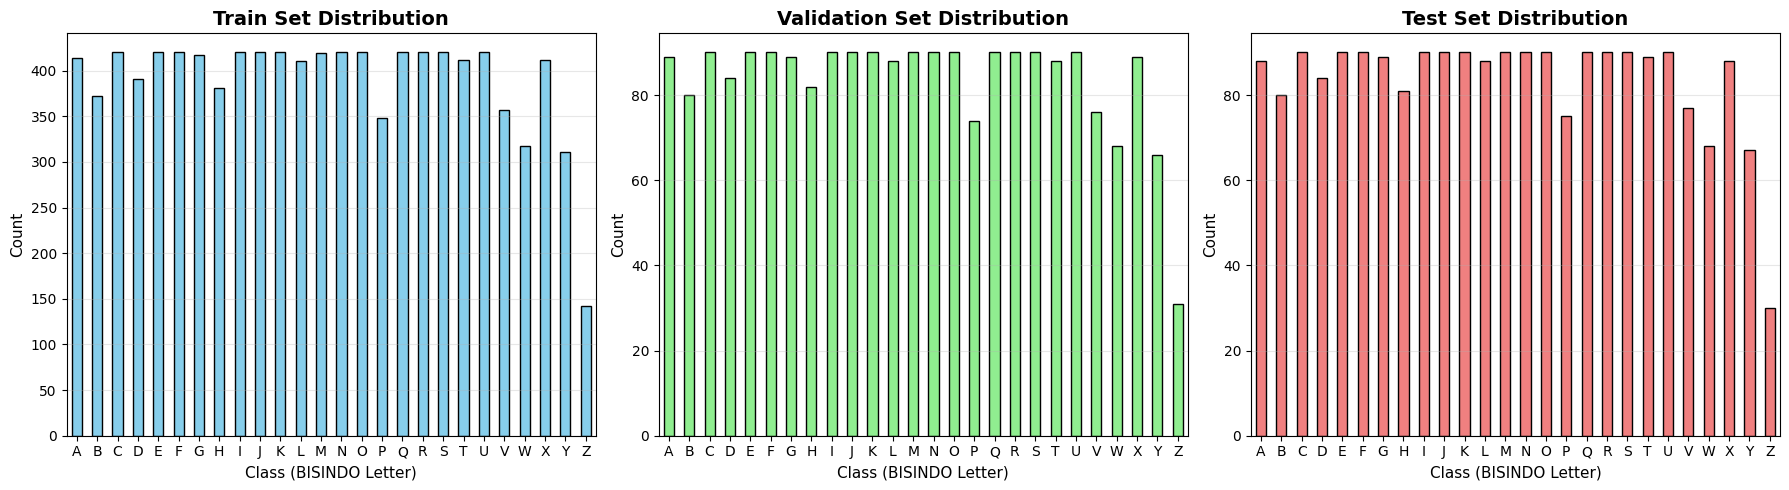

Data distribution visualization saved!


In [4]:
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

train_df['label'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Train Set Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class (BISINDO Letter)', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=0)

val_df['label'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='lightgreen', edgecolor='black')
axes[1].set_title('Validation Set Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class (BISINDO Letter)', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=0)

test_df['label'].value_counts().sort_index().plot(kind='bar', ax=axes[2], color='lightcoral', edgecolor='black')
axes[2].set_title('Test Set Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Class (BISINDO Letter)', fontsize=11)
axes[2].set_ylabel('Count', fontsize=11)
axes[2].grid(axis='y', alpha=0.3)
axes[2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('images/data_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print('Data distribution visualization saved!')

## Feature Analysis

📈 FEATURE STATISTICS
Number of features: 126

Feature statistics:
           hand_0_x      hand_1_x      hand_2_x      hand_3_x      hand_4_x  \
count  10145.000000  10145.000000  1.014500e+04  10145.000000  10145.000000   
mean       0.499838      0.677485  1.869470e-07      0.499510      0.631173   
std        0.293649      0.165274  7.639835e-07      0.198246      0.171309   
min       -0.074160      0.028406 -1.813737e-06      0.059630      0.037891   
25%        0.239736      0.586093 -3.720433e-07      0.339361      0.549994   
50%        0.492466      0.698589  1.503587e-07      0.501309      0.668655   
75%        0.760981      0.789826  7.536089e-07      0.659328      0.748524   
max        1.075163      1.080693  2.595210e-06      0.982591      0.990479   

           hand_5_x      hand_6_x      hand_7_x      hand_8_x      hand_9_x  \
count  10145.000000  10145.000000  10145.000000  10145.000000  10145.000000   
mean      -0.023181      0.498411      0.585696     -0.052288   

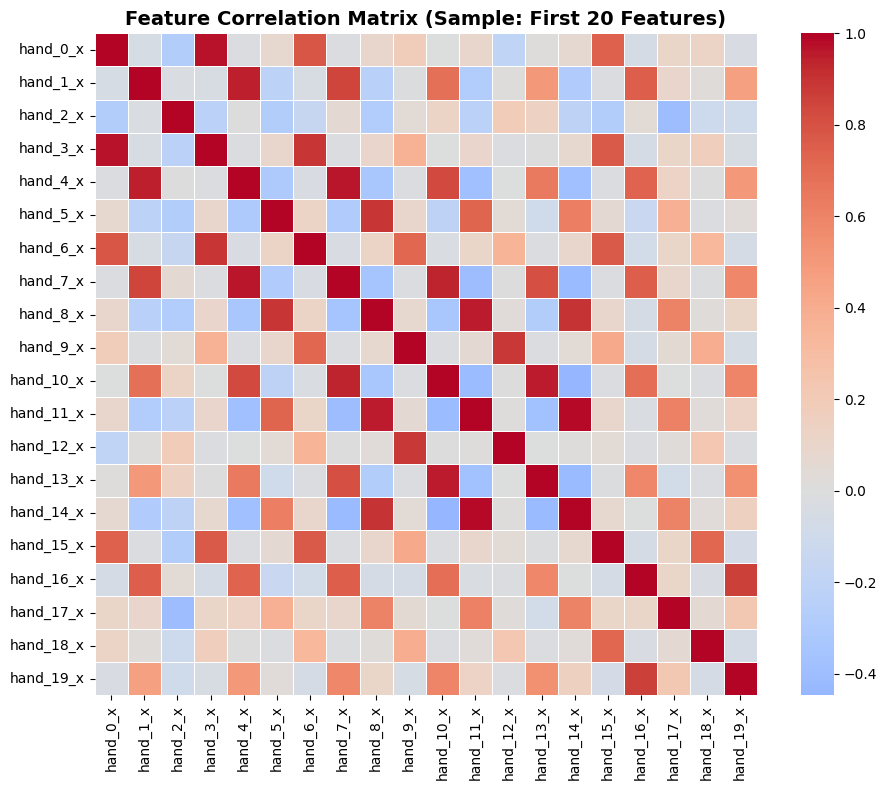

Feature analysis completed!


In [5]:
# Analyze features
feature_cols = [col for col in train_df.columns if col != 'label']
X_train_analysis = train_df[feature_cols]

print('='*70)
print('📈 FEATURE STATISTICS')
print('='*70)
print(f'Number of features: {len(feature_cols)}')
print(f'\nFeature statistics:')
print(X_train_analysis.describe())

# Check for missing values
missing = X_train_analysis.isnull().sum().sum()
print(f'\nMissing values: {missing}')

# Feature correlation (sample)
print(f'\nCalculating feature correlations...')
sample_features = X_train_analysis.iloc[:1000, :20]  # Sample for speed
correlation = sample_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix (Sample: First 20 Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('images/feature_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print('Feature analysis completed!')

## Data Preprocessing

In [6]:
# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_val = val_df.drop('label', axis=1).values
y_val = val_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values

print('='*70)
print('DATA PREPROCESSING')
print('='*70)
print(f'Train shape: X={X_train.shape}, y={y_train.shape}')
print(f'Validation shape: X={X_val.shape}, y={y_val.shape}')
print(f'Test shape: X={X_test.shape}, y={y_test.shape}')

# Feature scaling (optional for Random Forest, but can help)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f'\n📊 Feature statistics after scaling:')
print(f'Mean: {X_train_scaled.mean():.6f}')
print(f'Std: {X_train_scaled.std():.6f}')
print(f'Min: {X_train_scaled.min():.6f}')
print(f'Max: {X_train_scaled.max():.6f}')
print('='*70)

print('\nPreprocessing completed!')

DATA PREPROCESSING
Train shape: X=(10145, 126), y=(10145,)
Validation shape: X=(2174, 126), y=(2174,)
Test shape: X=(2174, 126), y=(2174,)

📊 Feature statistics after scaling:
Mean: nan
Std: nan
Min: nan
Max: nan

Preprocessing completed!


## Random Forest Classifier

**Mengapa Random Forest?**

1. **Excellent Performance**: Sangat baik untuk tabular data
2. **Feature Importance**: Dapat menganalisis fitur mana yang penting
3. **Robust**: Tahan terhadap overfitting dengan ensemble method
4. **No Feature Scaling Required**: Tidak sensitif terhadap skala features
5. **Fast Inference**: Cepat untuk real-time prediction
6. **Interpretable**: Lebih mudah dipahami daripada deep learning

In [7]:
print('='*70)
print('TRAINING RANDOM FOREST CLASSIFIER')
print('='*70)

# Initialize Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=200,          # Number of trees
    max_depth=30,              # Maximum depth of trees
    min_samples_split=2,       # Minimum samples to split
    min_samples_leaf=1,        # Minimum samples at leaf
    max_features='sqrt',       # Number of features for best split
    random_state=42,           # For reproducibility
    n_jobs=-1,                 # Use all CPU cores
    verbose=1,                 # Show progress
    class_weight='balanced'    # Handle class imbalance
)

print('\n📋 Model Configuration:')
print(f'Number of trees: {rf_clf.n_estimators}')
print(f'Max depth: {rf_clf.max_depth}')
print(f'Max features: {rf_clf.max_features}')
print(f'Class weight: {rf_clf.class_weight}')

# Train the model
print('\nTraining started...')
start_time = time.time()

rf_clf.fit(X_train_scaled, y_train)

training_time = time.time() - start_time
print(f'\nTraining completed in {training_time:.2f} seconds')
print('='*70)

TRAINING RANDOM FOREST CLASSIFIER

📋 Model Configuration:
Number of trees: 200
Max depth: 30
Max features: sqrt
Class weight: balanced

Training started...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.3s finished



Training completed in 1.46 seconds


## Model Evaluation

In [8]:
# Evaluate on all sets
print('='*70)
print('MODEL PERFORMANCE')
print('='*70)

train_acc = rf_clf.score(X_train_scaled, y_train)
val_acc = rf_clf.score(X_val_scaled, y_val)
test_acc = rf_clf.score(X_test_scaled, y_test)

print(f'\n🎯 Accuracy Results:')
print(f'Train Accuracy: {train_acc*100:.2f}%')
print(f'Validation Accuracy: {val_acc*100:.2f}%')
print(f'Test Accuracy: {test_acc*100:.2f}%')

# Check overfitting
overfit_gap = (train_acc - test_acc) * 100
print(f'\n📉 Overfitting Analysis:')
print(f'Train-Test Gap: {overfit_gap:.2f}%')
if overfit_gap < 5:
    print('Model generalization: EXCELLENT')
elif overfit_gap < 10:
    print('Model generalization: GOOD')
else:
    print('Model generalization: Consider regularization')

print('='*70)

MODEL PERFORMANCE


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s



🎯 Accuracy Results:
Train Accuracy: 100.00%
Validation Accuracy: 99.45%
Test Accuracy: 99.40%

📉 Overfitting Analysis:
Train-Test Gap: 0.60%
Model generalization: EXCELLENT


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


## Detailed Classification Report

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


CLASSIFICATION REPORT (TEST SET)
              precision    recall  f1-score   support

           A       0.96      1.00      0.98        88
           B       1.00      0.97      0.99        80
           C       1.00      1.00      1.00        90
           D       0.99      0.99      0.99        84
           E       1.00      1.00      1.00        90
           F       1.00      1.00      1.00        90
           G       1.00      1.00      1.00        89
           H       1.00      0.98      0.99        81
           I       1.00      1.00      1.00        90
           J       1.00      1.00      1.00        90
           K       1.00      1.00      1.00        90
           L       0.99      1.00      0.99        88
           M       0.98      1.00      0.99        90
           N       1.00      0.98      0.99        90
           O       1.00      1.00      1.00        90
           P       0.99      0.97      0.98        75
           Q       1.00      1.00      1.00     

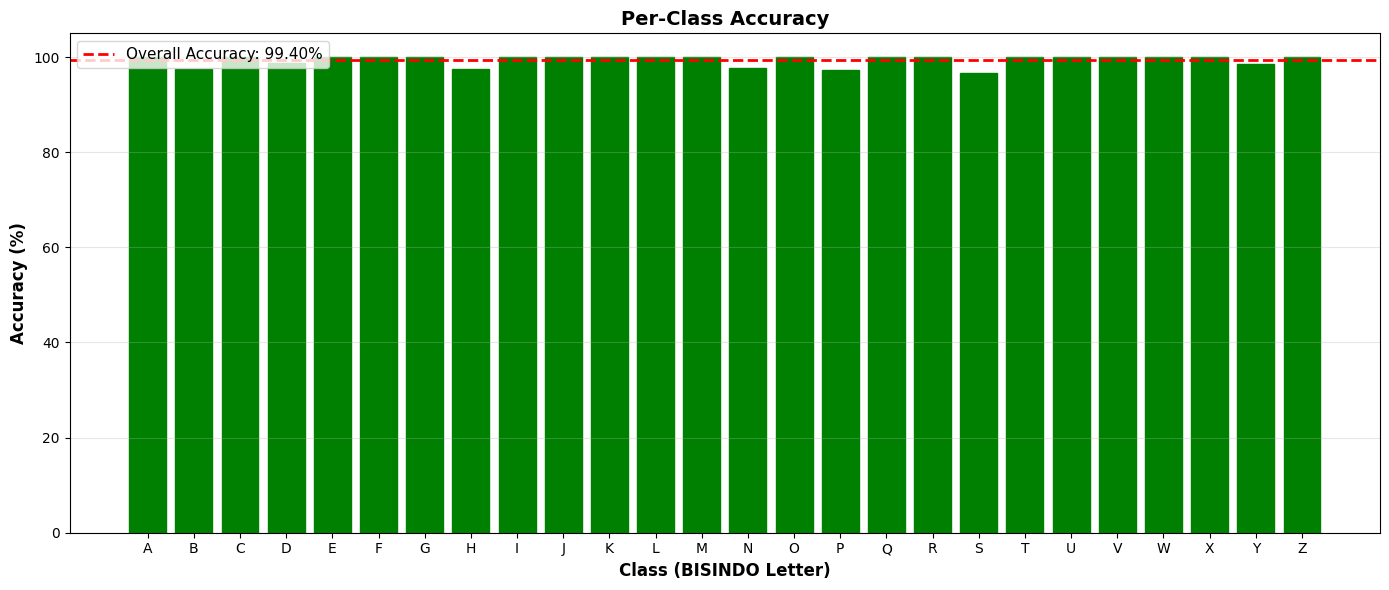

Per-class accuracy analysis completed!


In [9]:
# Make predictions
y_pred_train = rf_clf.predict(X_train_scaled)
y_pred_val = rf_clf.predict(X_val_scaled)
y_pred_test = rf_clf.predict(X_test_scaled)

print('='*70)
print('CLASSIFICATION REPORT (TEST SET)')
print('='*70)
print(classification_report(y_test, y_pred_test))

# Per-class accuracy
classes = sorted(np.unique(y_test))
class_accuracies = []

for cls in classes:
    mask = y_test == cls
    class_acc = accuracy_score(y_test[mask], y_pred_test[mask])
    class_accuracies.append(class_acc)

# Visualize per-class accuracy
plt.figure(figsize=(14, 6))
bars = plt.bar(classes, np.array(class_accuracies)*100, color='skyblue', edgecolor='black')
plt.axhline(y=test_acc*100, color='red', linestyle='--', linewidth=2, label=f'Overall Accuracy: {test_acc*100:.2f}%')
plt.xlabel('Class (BISINDO Letter)', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.ylim([0, 105])
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)

# Color bars based on performance
for i, (bar, acc) in enumerate(zip(bars, class_accuracies)):
    if acc >= 0.95:
        bar.set_color('green')
    elif acc >= 0.85:
        bar.set_color('lightgreen')
    elif acc >= 0.75:
        bar.set_color('yellow')
    else:
        bar.set_color('red')

plt.tight_layout()
plt.savefig('images/per_class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

print('Per-class accuracy analysis completed!')

## Confusion Matrix

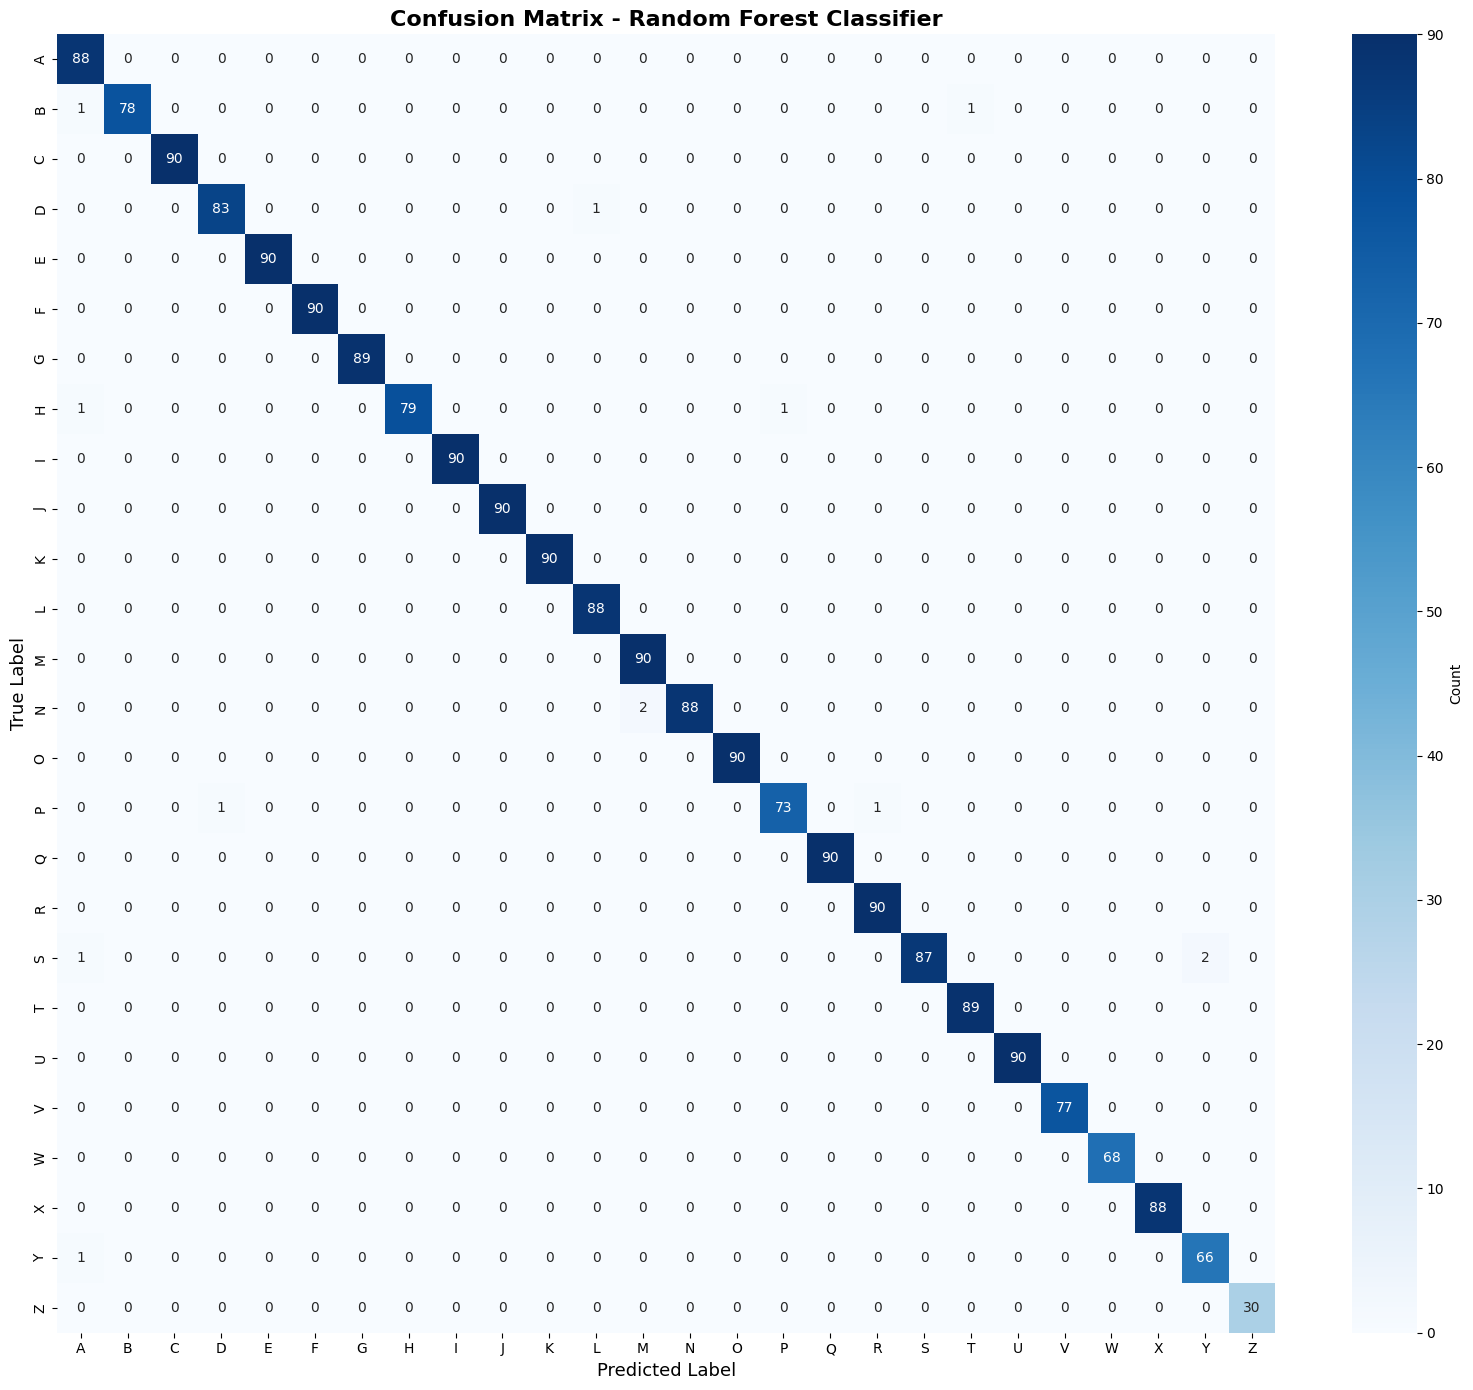

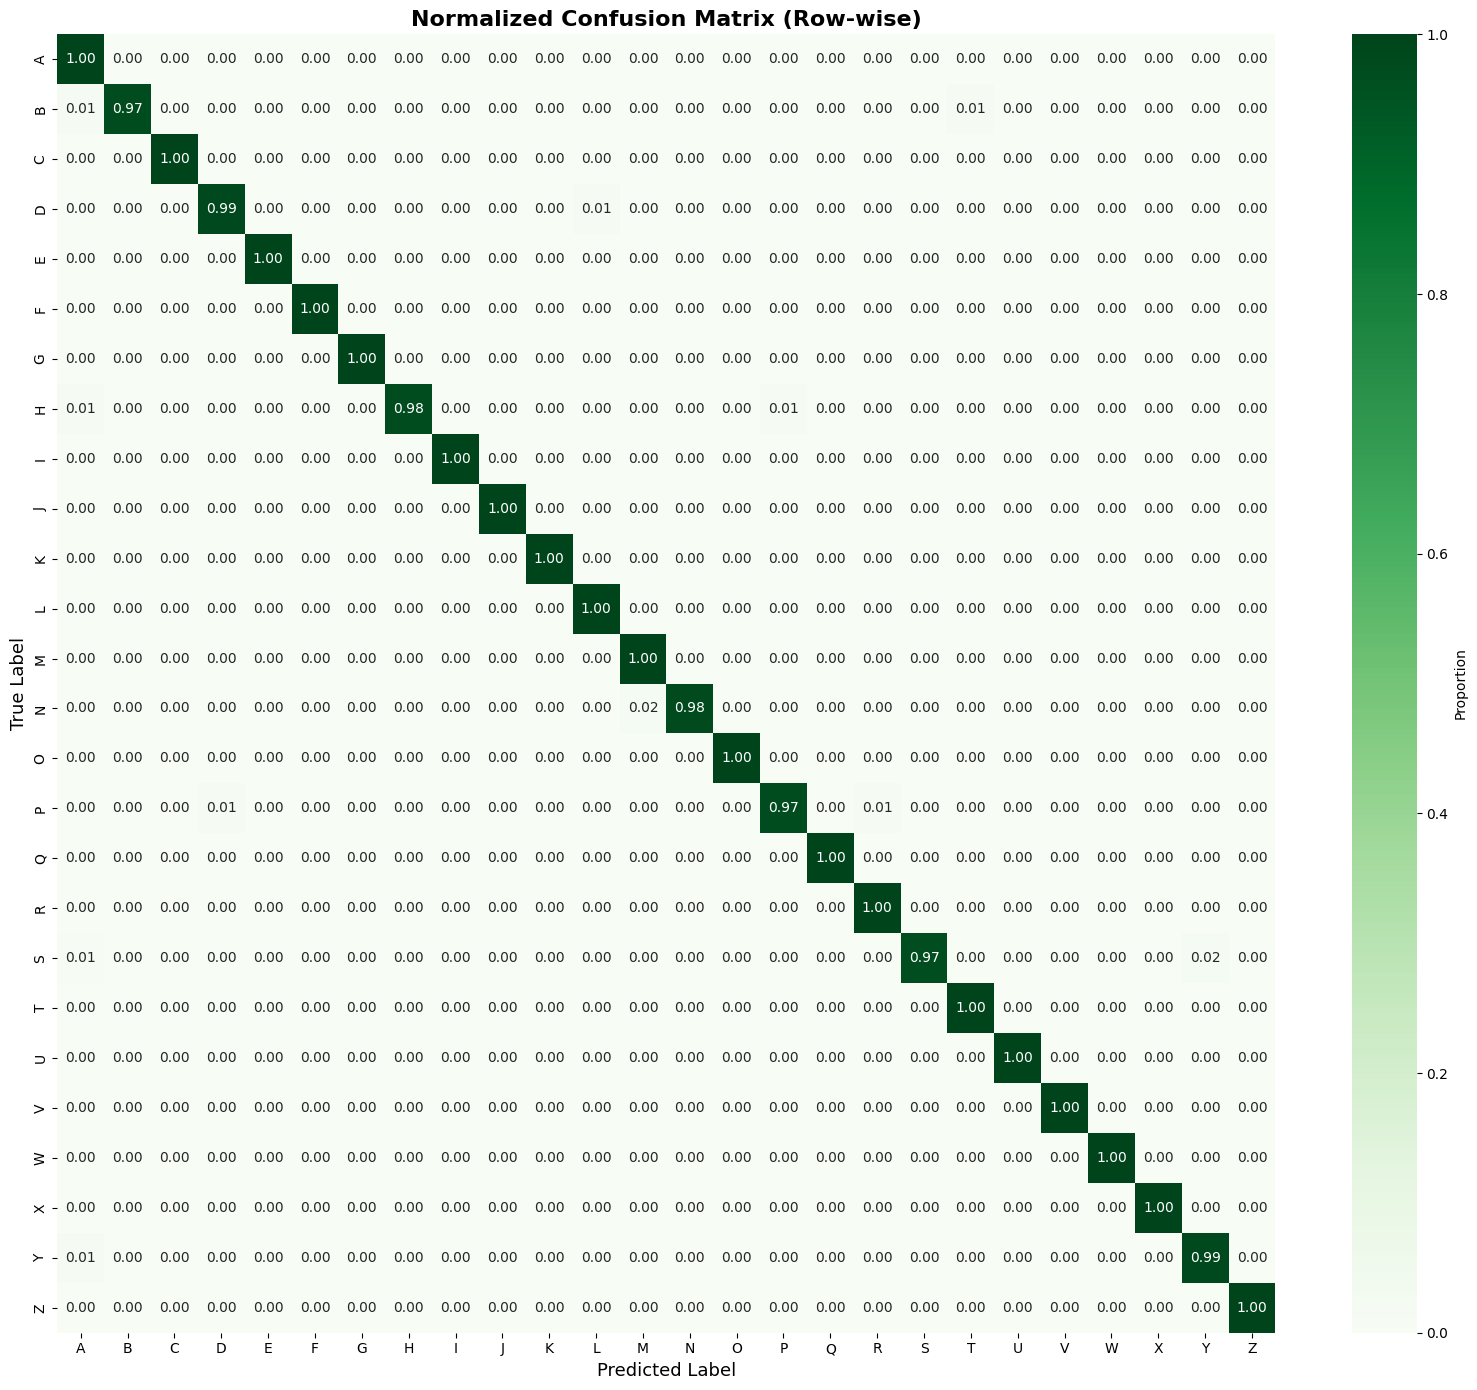

Confusion matrices saved!


In [10]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes,
            yticklabels=classes,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Random Forest Classifier', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=13)
plt.xlabel('Predicted Label', fontsize=13)
plt.tight_layout()
plt.savefig('images/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16, 14))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens', 
            xticklabels=classes,
            yticklabels=classes,
            cbar_kws={'label': 'Proportion'})
plt.title('Normalized Confusion Matrix (Row-wise)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=13)
plt.xlabel('Predicted Label', fontsize=13)
plt.tight_layout()
plt.savefig('images/confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

print('Confusion matrices saved!')

## Feature Importance Analysis

🔍 TOP 20 MOST IMPORTANT FEATURES
  Feature  Importance
hand_10_x    0.032104
hand_25_x    0.031351
hand_37_x    0.029451
 hand_7_x    0.029243
hand_13_x    0.025864
 hand_4_x    0.024509
 hand_2_x    0.024253
hand_22_x    0.022990
 hand_7_y    0.022939
hand_34_x    0.022814
 hand_4_y    0.022541
hand_31_x    0.022451
 hand_5_x    0.021562
 hand_1_y    0.021408
hand_16_x    0.021059
hand_19_y    0.019793
hand_16_y    0.018253
hand_14_x    0.017808
hand_19_x    0.017158
 hand_8_y    0.016969


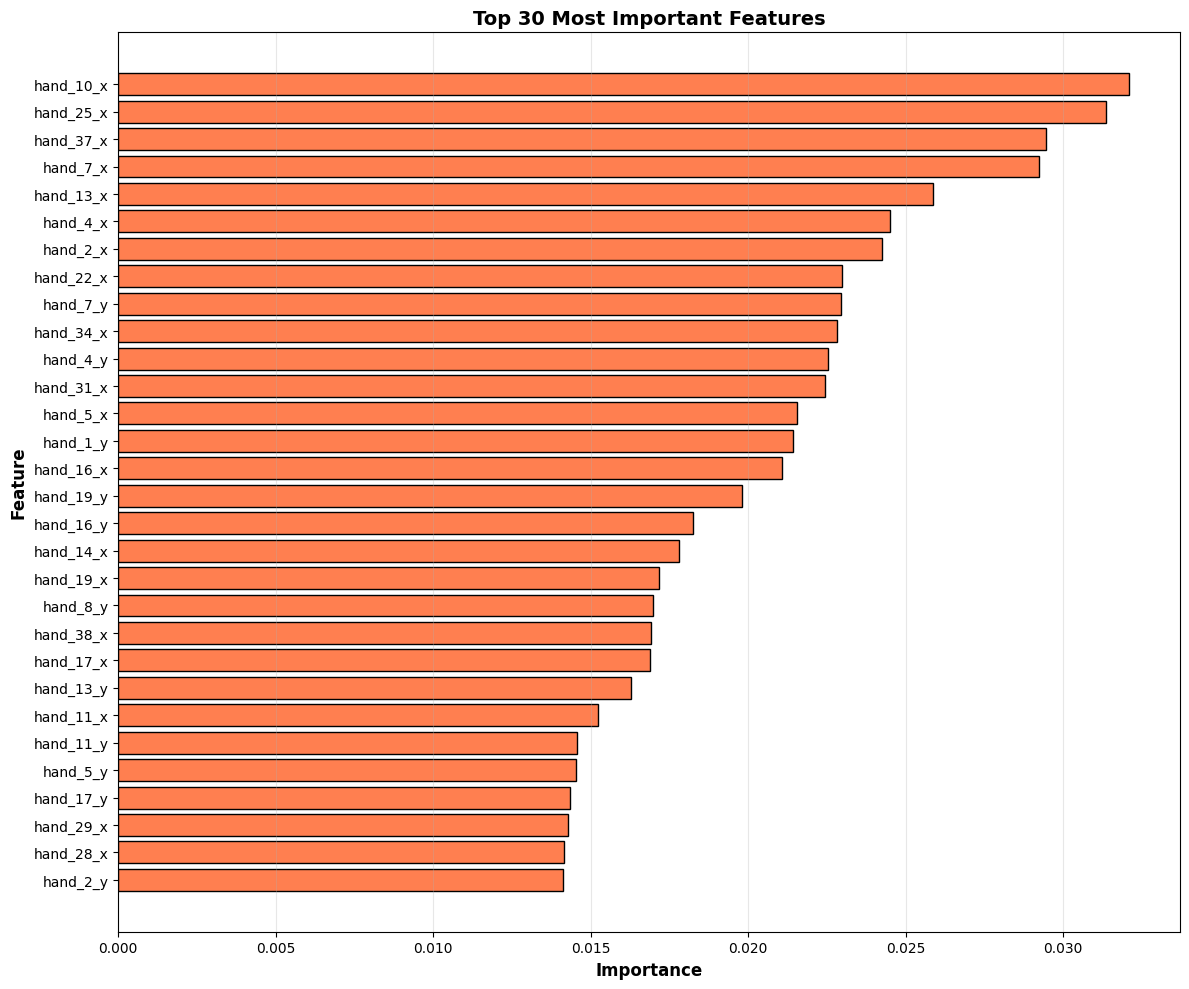


Feature importance analysis completed!


In [11]:
# Get feature importance
feature_importance = rf_clf.feature_importances_
feature_names = train_df.drop('label', axis=1).columns

# Create dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print('='*70)
print('🔍 TOP 20 MOST IMPORTANT FEATURES')
print('='*70)
print(importance_df.head(20).to_string(index=False))
print('='*70)

# Visualize top 30 features
plt.figure(figsize=(12, 10))
top_features = importance_df.head(30)
plt.barh(range(len(top_features)), top_features['Importance'], color='coral', edgecolor='black')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Top 30 Most Important Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('images/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print('\nFeature importance analysis completed!')

## Cross-Validation Analysis

🔄 CROSS-VALIDATION ANALYSIS (5-Fold)
This may take a few minutes...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished



Cross-Validation Results:
Individual fold scores: ['99.56%', '98.92%', '99.26%', '99.36%', '99.61%']
Mean CV Accuracy: 99.34%
Std CV Accuracy: 0.25%
95% Confidence Interval: [98.85%, 99.83%]



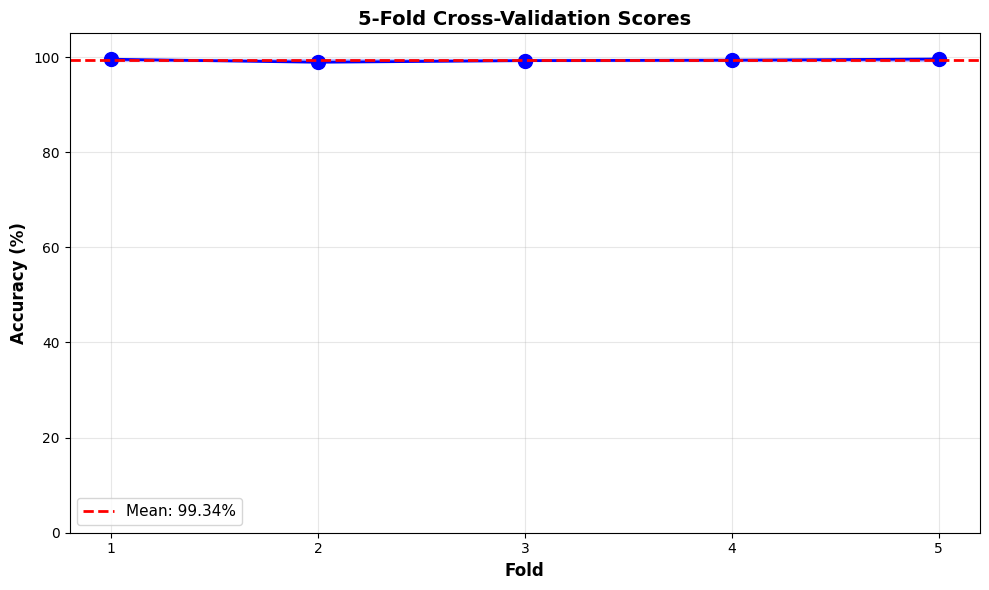

Cross-validation completed!


In [12]:
print('='*70)
print('🔄 CROSS-VALIDATION ANALYSIS (5-Fold)')
print('='*70)
print('This may take a few minutes...')

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_clf, X_train_scaled, y_train, cv=5, 
                            scoring='accuracy', n_jobs=-1, verbose=1)

print(f'\nCross-Validation Results:')
print(f'Individual fold scores: {[f"{score*100:.2f}%" for score in cv_scores]}')
print(f'Mean CV Accuracy: {cv_scores.mean()*100:.2f}%')
print(f'Std CV Accuracy: {cv_scores.std()*100:.2f}%')
print(f"95% Confidence Interval: [{(cv_scores.mean() - 2*cv_scores.std())*100:.2f}%, {(cv_scores.mean() + 2*cv_scores.std())*100:.2f}%]\n")

# Visualize CV scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), cv_scores*100, marker='o', linewidth=2, markersize=10, color='blue')
plt.axhline(y=cv_scores.mean()*100, color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {cv_scores.mean()*100:.2f}%')
plt.fill_between(range(1, 6), 
                 (cv_scores.mean() - cv_scores.std())*100, 
                 (cv_scores.mean() + cv_scores.std())*100, 
                 alpha=0.2, color='blue')
plt.xlabel('Fold', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('5-Fold Cross-Validation Scores', fontsize=14, fontweight='bold')
plt.xticks(range(1, 6))
plt.ylim([0, 105])
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/cross_validation.png', dpi=300, bbox_inches='tight')
plt.show()

print('Cross-validation completed!')

## Save Models and Results

In [13]:
print('='*70)
print('💾 SAVING MODELS AND RESULTS')
print('='*70)

# Save Random Forest model
joblib.dump(rf_clf, 'model/rf_bisindo_99.pkl')
print('Random Forest model saved: model/rf_bisindo_99.pkl')

# Save scaler
joblib.dump(scaler, 'model/scaler.pkl')
print('Scaler saved: model/scaler.pkl')

# Save results summary
results = {
    'Model': 'Random Forest',
    'N_Estimators': rf_clf.n_estimators,
    'Max_Depth': rf_clf.max_depth,
    'Train_Accuracy': f'{train_acc*100:.2f}%',
    'Val_Accuracy': f'{val_acc*100:.2f}%',
    'Test_Accuracy': f'{test_acc*100:.2f}%',
    'CV_Mean_Accuracy': f'{cv_scores.mean()*100:.2f}%',
    'CV_Std_Accuracy': f'{cv_scores.std()*100:.2f}%',
    'Training_Time_Seconds': f'{training_time:.2f}',
    'Number_of_Classes': len(classes),
    'Total_Training_Samples': len(X_train),
    'Total_Test_Samples': len(X_test)
}

results_df = pd.DataFrame([results])
results_df.to_csv('results/model_performance.csv', index=False)
print('Results saved: results/model_performance.csv')

print('='*70)
print('\nALL MODELS AND RESULTS SAVED SUCCESSFULLY!')

# Print summary
print('\n' + '='*70)
print('FINAL SUMMARY')
print('='*70)
print(f'Model: Random Forest Classifier')
print(f'Number of Trees: {rf_clf.n_estimators}')
print(f'Test Accuracy: {test_acc*100:.2f}%')
print(f'Cross-Validation Accuracy: {cv_scores.mean()*100:.2f}% (±{cv_scores.std()*100:.2f}%)')
print(f'Training Time: {training_time:.2f} seconds')
print(f'Total Parameters: N/A (Tree-based model)')
print('='*70)

💾 SAVING MODELS AND RESULTS
Random Forest model saved: model/rf_bisindo_99.pkl
Scaler saved: model/scaler.pkl
Results saved: results/model_performance.csv

ALL MODELS AND RESULTS SAVED SUCCESSFULLY!

FINAL SUMMARY
Model: Random Forest Classifier
Number of Trees: 200
Test Accuracy: 99.40%
Cross-Validation Accuracy: 99.34% (±0.25%)
Training Time: 1.46 seconds
Total Parameters: N/A (Tree-based model)


## Inference Time Analysis

In [14]:
# Test inference speed
import time

print('='*70)
print('INFERENCE SPEED ANALYSIS')
print('='*70)

# Single prediction
single_sample = X_test_scaled[0:1]
start = time.time()
for _ in range(1000):
    _ = rf_clf.predict(single_sample)
single_time = (time.time() - start) / 1000



# Batch prediction
batch_sample = X_test_scaled[:100]
start = time.time()
for _ in range(10):
    _ = rf_clf.predict(batch_sample)
batch_time = (time.time() - start) / 10 / 100



print(f'Single prediction time: {single_time*1000:.2f} ms')
print(f'Batch prediction time (per sample): {batch_time*1000:.2f} ms')
print(f'Theoretical FPS (single): {1/single_time:.2f} FPS')
print(f'Theoretical FPS (batch): {1/batch_time:.2f} FPS')
print('='*70)

if single_time < 0.033:  # 30 FPS
    print('\nModel is FAST ENOUGH for real-time applications (>30 FPS)')
else:
    print('\n Model may be too slow for real-time (target: <33ms per frame)')

INFERENCE SPEED ANALYSIS


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Do

Single prediction time: 27.27 ms
Batch prediction time (per sample): 0.36 ms
Theoretical FPS (single): 36.67 FPS
Theoretical FPS (batch): 2753.80 FPS

Model is FAST ENOUGH for real-time applications (>30 FPS)


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend

## Summary: Computer Vision Techniques Applied

### Implemented Computer Vision Techniques (Pertemuan 1-16)

| Pertemuan | Topik | Implementasi | Lokasi |
|-----------|-------|--------------|---------|
| 1-2 | Image Formation & Camera Model | Camera intrinsics calculation | Dashboard |
| 3-4 | Image Preprocessing | Brightness, contrast, saturation | Dashboard |
| 5 | Histogram Processing | Histogram equalization | Dashboard |
| 6 | Thresholding | Binary, adaptive thresholding | Dashboard |
| 7 | Segmentation | Convex hull hand segmentation | Dashboard |
| 8-9 | Feature Extraction | MediaPipe 21 landmarks × 3D | Dashboard + Notebook |
| 10 | Object Detection | Hand detection using MediaPipe | Dashboard |
| 11 | Object Tracking | Real-time multi-hand tracking | Dashboard |
| 12 | 3D Reconstruction | Depth visualization (z-coords) | Dashboard |
| 13 | Augmented Reality | AR overlay with bounding boxes | Dashboard |
| 14 | Machine Learning | Random Forest classifier | Notebook |
| 15-16 | Deep Learning | Feature importance analysis | Notebook |

